# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import xgboost as xgb

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

In [7]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'rice_export_amount', 'inflation', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'w

# Model

In [9]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars_export_finance = ['agri_export_value', 'rice_export_value', 
                    'rice_export_amount', 'pol_rate', 'neer', 'reer','inflation' , 'cpi_rice']

# Adjust X to match the same periods
X = df[xvars_export_finance]

In [10]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 8), (25, 8), (201,), (25,))

In [11]:
X_train['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01') else 0 for date in y_train.index]
X_test['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01')  else 0 for date in y_test.index]

X_train['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01') else 0 for date in y_train.index]
X_test['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01')  else 0 for date in y_test.index]

X_train['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01') else 0 for date in y_train.index]
X_test['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01')  else 0 for date in y_test.index]

X_train['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01') else 0 for date in y_train.index]
X_test['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01')  else 0 for date in y_test.index]


# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [14]:
label = 'nonglu_price'
df = df[xvars_export_finance + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [15]:
X_train['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01') else 0 for date in y_train.index]
X_test['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01')  else 0 for date in y_test.index]

X_train['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01') else 0 for date in y_train.index]
X_test['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01')  else 0 for date in y_test.index]

X_train['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01') else 0 for date in y_train.index]
X_test['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01')  else 0 for date in y_test.index]

X_train['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01') else 0 for date in y_train.index]
X_test['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01')  else 0 for date in y_test.index]


# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

In [16]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 12), (25, 12), (201,), (25,))

In [18]:
# Prediction
y_pred = lr.predict(X_test)

In [19]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 618049.5409
Linear Regression Model RMSE: 786.1613
Linear Regression Model R-squared: 0.4380


In [20]:
# Create Score Dataframe
lr_score = pd.DataFrame(data = {'model': ['Linear'] * 3,
                                   'metric':['MSE','RMSE','R2'],'score':[lr_mse,lr_rmse,lr_r2]})
lr_score

,model,metric,score
0,Linear,MSE,618049.540886
1,Linear,RMSE,786.161269
2,Linear,R2,0.438008


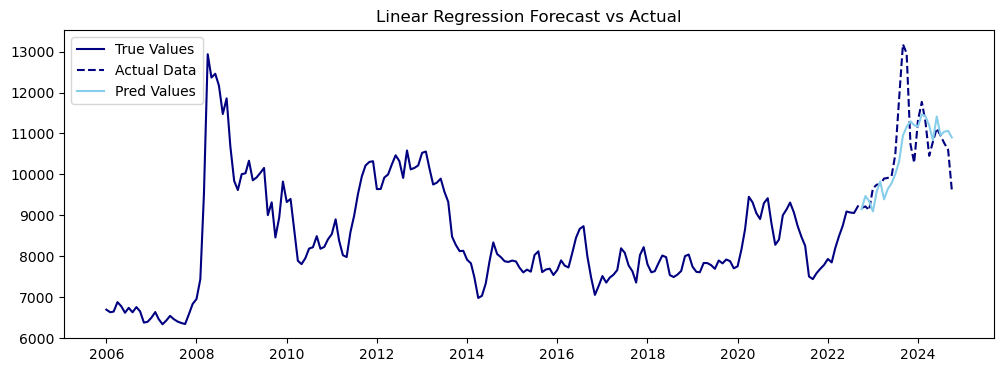

In [21]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/export_finance/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

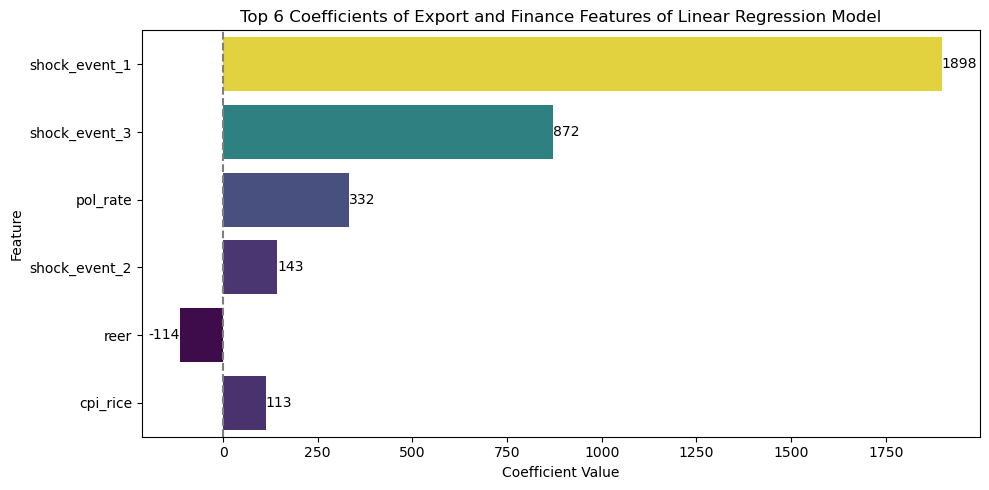

In [218]:
# Assuming `model` is your linear regression model and `X_train` is the training dataset
# Extract feature names and coefficients
coefficients = lr.coef_  # Replace with the attribute for coefficients in your model
feature_names = X_train.columns

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of coefficients in descending order
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Get the top 10 highest coefficients
top_6_coef = coef_df.head(6)

# Plot the top 10 coefficients
plt.figure(figsize=(10,5))
ax = sns.barplot(y='Feature', x='Coefficient',hue = 'Coefficient', data=top_5_coef, palette='viridis')
plt.title('Top 6 Coefficients of Export and Finance Features of Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linestyle='--')  # Reference line at 0
plt.tight_layout()

# Annotate bars with values
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10)

# Remove the legend
if ax.legend_:
    ax.legend_.remove()

# Save the plot
plt.savefig("../figure/top_6_coefficients.png", transparent=True)
plt.show()

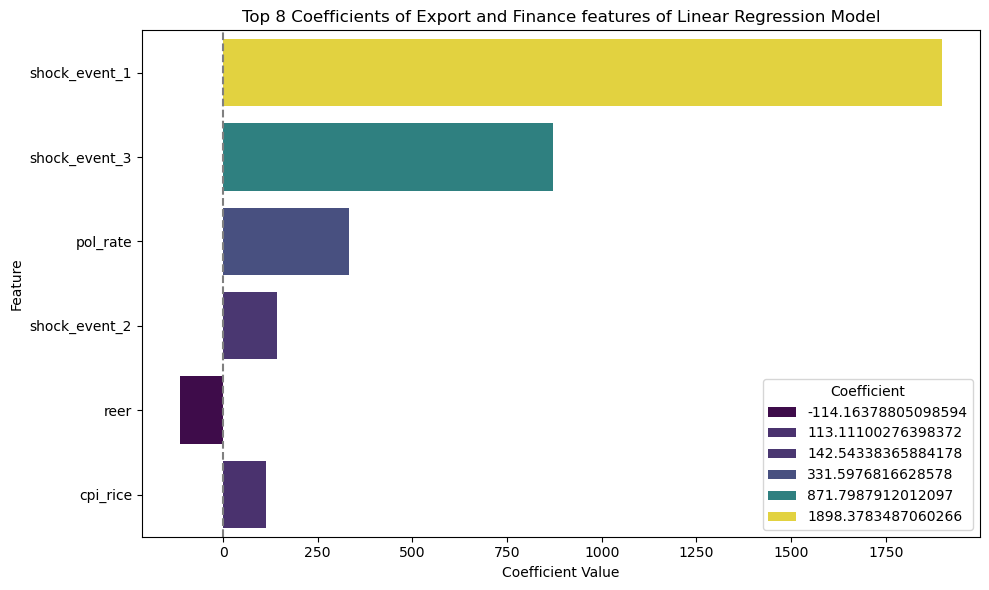

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming `model` is your linear regression model and `X_train` is the training dataset
# Extract feature names and coefficients
coefficients = lr.coef_  # Replace with the attribute for coefficients in your model
feature_names = X_train.columns

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of coefficients in descending order
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Get the top 10 highest coefficients
top_5_coef = coef_df.head(6)

# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
ax = sns.barplot(y='Feature', x='Coefficient', data=top_5_coef, hue= 'Coefficient', palette='viridis')
plt.title('Top 8 Coefficients of Export and Finance features of Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linestyle='--')  # Reference line at 0
plt.tight_layout()

# Annotate bars with values
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10)

# Save the plot
plt.savefig("../figure/top_coefficients.png")
plt.show()


In [139]:
coef_df.columns

RangeIndex(start=0, stop=2, step=1)

In [133]:
coef_df

,0,1
0,agri_export_value,-0.284514
1,rice_export_value,11.203949
2,rice_export_amount,-0.005730
3,pol_rate,331.597682
4,neer,51.786433
5,reer,-114.163788
6,inflation,-10.862035
7,cpi_rice,113.111003


In [ ]:

# Sort the DataFrame by the absolute value of coefficients in descending order
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
sns.barplot(y='feature', x='coefficient', data=top_10_coef, palette='viridis')
plt.title('Top 10 Highest Coefficients of Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linestyle='--')  # Reference line at 0
plt.tight_layout()

# Save the plot
plt.savefig("../figure/top_10_highest_coefficients.png")
plt.show()


## 2. ARIMA Model

### Model 2 : ARIMA

In [26]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [27]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [28]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 1345287.1633
ARIMAX(2,1,2) Model RMSE :1159.8651
ARIMAX(2,1,2) Model R-squared :-0.2233


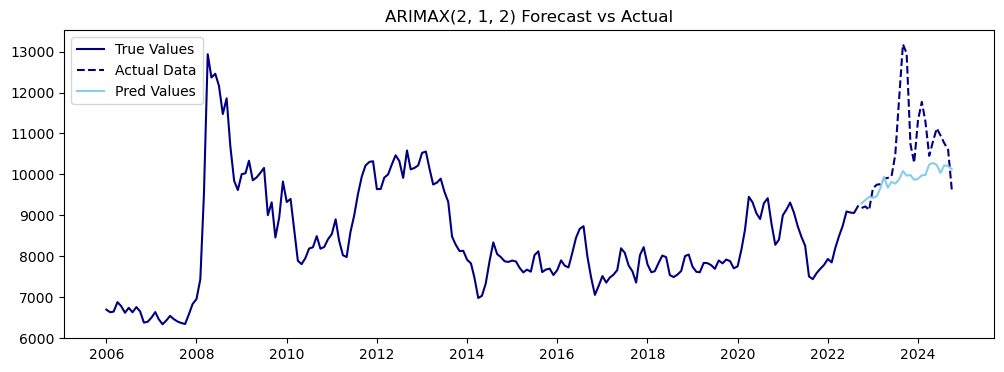

In [29]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/export_finance/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [31]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1457.300
Date:                Thu, 19 Dec 2024   AIC                           2948.600
Time:                        14:21:52   BIC                           3004.671
Sample:                    01-01-2006   HQIC                          2971.291
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
agri_export_value      0.2926      0.237      1.233      0.218      -0.173       0.758
rice_export_value      1.4143      1.145      1.235      0.217      -0.831       3.659
rice_export_amount    -0.0007      0.001     -1.327      0.184      -0.002       0.000
pol_rate             177.5609    241.635      0.735      0.462    -296.035     651.157
neer                  44.4585    103.632      0.429      0.668    -158.656     247.573
reer                 -44.6376    106.742     -0.418      0.676    -253.848     164.573
inflation             53.9374     93.443      0.577      0.564    -129.207     237.082
cpi_rice              52.8409     22.646      2.333      0.020       8.456      97.226
shock_event_1         -3.5117   1731.947     -0.002      0.998   -3398.066    3391.042
shock_event_2       2438.6596    826.345      2.951      0.003     819.054    4058.265
shock_event_3         13.6491   3048.074      0.004      0.996   -5960.466    5987.764
shock_event_4               0      0.002          0      1.000      -0.004       0.004
ar.L1                  0.0452      0.754      0.060      0.952      -1.432       1.523
ar.L2                 -0.5432      0.488     -1.112      0.266      -1.500       0.414
ma.L1                  0.0395      0.758      0.052      0.958      -1.446       1.525
ma.L2                  0.4976      0.531      0.937      0.349      -0.543       1.538
sigma2              1.262e+05    243.683    518.045      0.000    1.26e+05    1.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               148.48
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.27e+25. Standard errors may be unstable.
"""

### Model 3 : Auto ARIMA

In [33]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        14:21:52   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [34]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [35]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 688009.5948
ARIMAX(2,0,0) Model RMSE :829.4634
ARIMAX(2,0,0) Model R-squared :0.3744


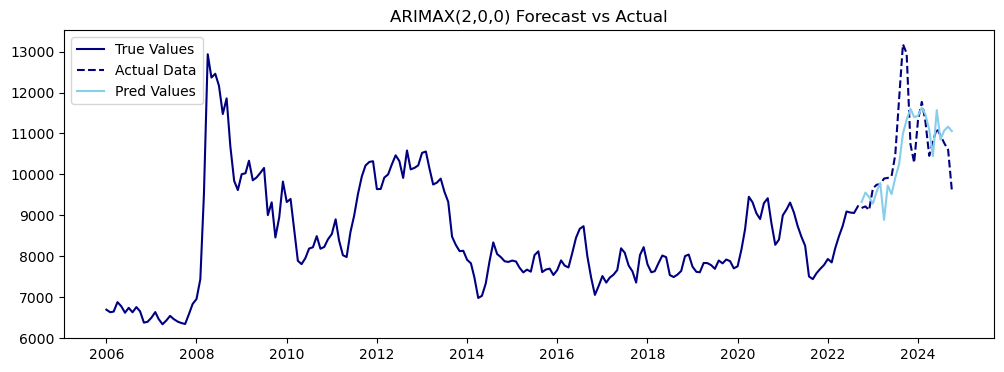

In [36]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/export_finance/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [38]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1513.116
Date:                Thu, 19 Dec 2024   AIC                           3058.233
Time:                        14:21:53   BIC                           3111.086
Sample:                    01-01-2006   HQIC                          3079.619
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.329e+04   2751.399      4.829      0.000    7894.662    1.87e+04
agri_export_value     -0.6511      0.221     -2.944      0.003      -1.085      -0.218
rice_export_value     11.1098      0.954     11.649      0.000       9.241      12.979
rice_export_amount    -0.0048      0.000    -11.043      0.000      -0.006      -0.004
pol_rate             331.5967    177.478      1.868      0.062     -16.254     679.447
neer                  51.7379     45.762      1.131      0.258     -37.955     141.430
reer                -114.2102     57.400     -1.990      0.047    -226.712      -1.708
inflation            -10.9055     33.162     -0.329      0.742     -75.902      54.091
cpi_rice             113.1110     24.963      4.531      0.000      64.185     162.037
shock_event_1       1898.3778    181.930     10.435      0.000    1541.801    2254.954
shock_event_2        142.5430    419.181      0.340      0.734    -679.036     964.123
shock_event_3        871.7987    299.072      2.915      0.004     285.628    1457.969
shock_event_4               0   2.49e-14          0      1.000   -4.88e-14    4.88e-14
ar.L1                  0.6642      0.101      6.566      0.000       0.466       0.862
ar.L2                  0.0653      0.109      0.601      0.548      -0.148       0.278
sigma2              2.208e+05     95.853   2304.025      0.000    2.21e+05    2.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):                35.57
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+26. Standard errors may be unstable.
"""

## 4. GARCH Model

### Model 4 : GARCH

In [41]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [42]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 812248.1243
GARCH Model RMSE :901.2481
GARCH Model R-squared :0.2614


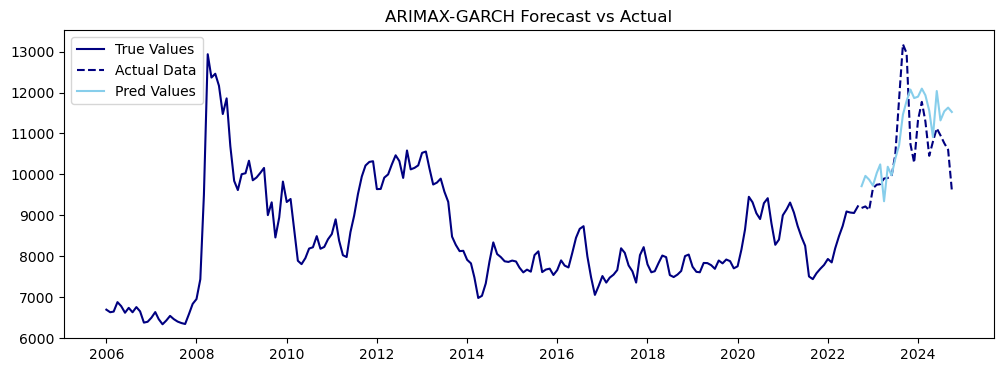

In [43]:
# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/export_finance/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [45]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 59928.50991129431
alpha (ARCH term): 0.3653120996302675
beta (GARCH term): 0.3596206917302812


# Compare the score of models

In [47]:
score_df = pd.DataFrame(data = {'feature' : ['export and finance'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/export_finance.csv',index=False)
score_df

,feature,model,MSE,RMSE,R2
0,export and finance,Linear,618049.540886,786.161269,0.438008
1,export and finance,"ARIMAX(2,0,0)",688009.594822,829.463438,0.374394
2,export and finance,GARCH,812248.124266,901.248093,0.261424
